## Recommendation System Of films using SARSA

### 🧠 Project goal :
Build an intelligent recommendation system that learns to suggest the most relevant content to users by analysing their interactions (clicks, time spent, etc.). The system uses the reinforcement learning algorithm SARSA (State-Action-Reward-State-Action) to learn an optimised recommendation policy.



#### Labraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


#### Load data

In [25]:
df = pd.read_csv("data/merged_movie_data.csv",sep=';')

In [26]:
df.sample(10)


,userId,movieId,rating,timestamp,title,genres
65556,420,8464,4.5,1218207751,Super Size Me (2004),Comedy|Documentary|Drama
66898,432,3156,3.0,1335139782,Bicentennial Man (1999),Drama|Romance|Sci-Fi
81787,517,6794,0.5,1487955808,Beethoven's 2nd (1993),Children|Comedy
79360,492,778,2.0,863976201,Trainspotting (1996),Comedy|Crime|Drama
94266,599,7439,2.0,1498510942,"Punisher, The (2004)",Action|Crime|Thriller
81498,515,122918,5.0,1513602063,Guardians of the Galaxy 2 (2017),Action|Adventure|Sci-Fi
77417,483,1729,3.5,1327277503,Jackie Brown (1997),Crime|Drama|Thriller
12141,74,8341,3.5,1207499990,Oliver Twist (1948),Adventure|Crime|Drama
71016,453,2770,4.0,1005967269,Bowfinger (1999),Comedy
45961,305,293,3.5,1460135877,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller


#### Re-indexing


**=> userId for Q-Table rows** 

**=> movieId for Q-Table columns** 

**=> idx_to_movie when argmax(Q[“state”]) is extracted to translate the index into a real movieId**.

In [27]:
user_to_idx = {uid: idx for idx, uid in enumerate(sorted(df['userId'].unique()))}
movie_to_idx = {mid: idx for idx, mid in enumerate(sorted(df['movieId'].unique()))}
idx_to_movie = {idx: mid for mid, idx in movie_to_idx.items()}
idx_to_title = dict(zip(df['movieId'], df['title']))
movie_genres = dict(zip(df['movieId'], df['genres']))

In [28]:
n_users = len(user_to_idx)
n_movies = len(movie_to_idx)

#### Extract all possible movie genres


In [33]:
genre_set = set()
for g in df['genres']:
    if isinstance(g, str):
        genre_set.update(g.split('|'))
        
all_genres = sorted(genre_set)
genre_to_idx = {g: i for i, g in enumerate(all_genres)}

#### Genre coding for each film

In [9]:
def encoder_genres(genre_str):
    vector = np.zeros(len(all_genres))
    for g in genre_str.split('|'):
        if g in genre_to_idx:
            vector[genre_to_idx[g]] = 1
    return vector

In [36]:
movie_genre_vectors = {mid: encoder_genres(genre_str) if isinstance(genre_str, str) else np.zeros(len(all_genres)) for mid, genre_str in movie_genres.items()}


#### Q-table


In [40]:
q_table = np.zeros((n_users, n_movies))

# Hyperparamètres
alpha,gamma,epsilon,episodes ,max_steps,coeff_genre = 0.1, 0.9, 0.1,500, 10, 0.5


#### Politique ε-greedy


In [39]:
def choisir_action(user_idx):
    if np.random.rand() < epsilon:
        return np.random.randint(n_movies)
    else:
        return np.argmax(q_table[user_idx])

#### Get a user's favorite genres



In [43]:

def genres_utilisateur(user_id):
    liked = df[(df['userId'] == user_id) & (df['rating'] >= 3.0)]
    if liked.empty:
        return np.zeros(len(all_genres))
    vectors = np.array([movie_genre_vectors[mid] for mid in liked['movieId'] if mid in movie_genre_vectors])
    return vectors.mean(axis=0)

#### Gender affinity awards



In [42]:
def obtenir_recompense(user_idx, movie_idx):
    user_id = list(user_to_idx.keys())[user_idx]
    movie_id = list(movie_to_idx.keys())[movie_idx]

    note_row = df[(df['userId'] == user_id) & (df['movieId'] == movie_id)]
    note_reward = 1 if not note_row.empty and note_row['rating'].values[0] >= 3.0 else 0

    user_pref = genres_utilisateur(user_id)
    movie_vec = movie_genre_vectors.get(movie_id, np.zeros(len(all_genres)))
    genre_similarity = np.dot(user_pref, movie_vec) / (np.linalg.norm(user_pref) + 1e-5)

    return note_reward + coeff_genre * genre_similarity

#### SARSA training



In [44]:
# Training loop
clics_par_episode = []

for ep in tqdm(range(episodes), desc="Training SARSA"):
    total_reward = 0
    for user_id in user_to_idx:
        user_idx = user_to_idx[user_id]
        state = choisir_action(user_idx)

        for _ in range(max_steps):
            action = choisir_action(user_idx)
            reward = obtenir_recompense(user_idx, action)
            next_state = choisir_action(user_idx)
            q_table[user_idx, state] += alpha * (
                reward + gamma * q_table[user_idx, next_state] - q_table[user_idx, state]
            )
            state = next_state
            total_reward += reward

    clics_par_episode.append(total_reward)

Training SARSA: 100%|██████████| 500/500 [3:06:07<00:00, 22.34s/it]  


#### Plot training curve


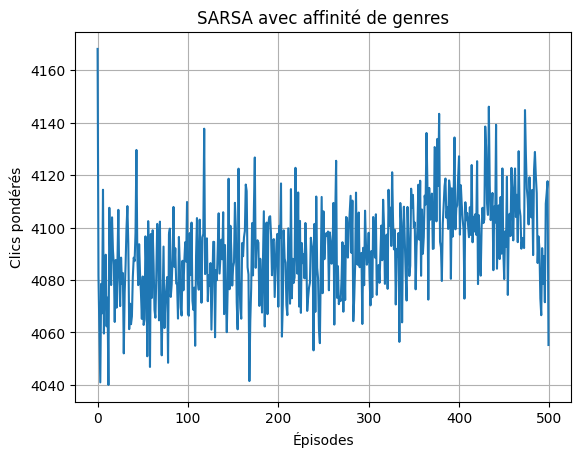

In [45]:
plt.plot(clics_par_episode)
plt.title("SARSA avec affinité de genres")
plt.xlabel("Épisodes")
plt.ylabel("Clics pondérés")
plt.grid()
plt.show()


#### Recommend N unseen movies to a user


In [48]:
def recommend_movies_for_user(user_id, N=5):
    user_idx = user_to_idx[user_id]
    seen_movies = set(df[df['userId'] == user_id]['movieId'])
    unseen_movie_indices = [idx for idx in range(n_movies) if idx_to_movie[idx] not in seen_movies]
    q_values = [(idx, q_table[user_idx, idx]) for idx in unseen_movie_indices]
    top_q = sorted(q_values, key=lambda x: x[1], reverse=True)[:N]
    return [(idx_to_movie[idx], idx_to_title[idx_to_movie[idx]], q) for idx, q in top_q]


#### Generate recommendations for all users and save to CSV


In [49]:
recommendations = []

for user_id in tqdm(user_to_idx.keys(), desc="Generating recommendations"):
    recs = recommend_movies_for_user(user_id, N=5)
    for movie_id, title, score in recs:
        recommendations.append({
            'userId': user_id,
            'movieId': movie_id,
            'title': title,
            'Q_value': round(score, 4)
        })

Generating recommendations: 100%|██████████| 610/610 [00:07<00:00, 76.57it/s] 


In [50]:
recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_csv("data/recommendations_sarsa.csv", index=False)
print("✅ Recommendations saved to data/recommendations_sarsa.csv")

✅ Recommendations saved to data/recommendations_sarsa.csv


In [51]:
df_reco1 = pd.read_csv("data/recommendations_sarsa.csv")

In [52]:
df_reco1.head(10)

,userId,movieId,title,Q_value
0,1,170937,Win It All (2017),1.1940
1,1,5581,Betsy's Wedding (1990),0.2577
2,1,59727,"Strangers, The (2008)",0.2424
3,1,169982,Power Rangers (2017),0.2347
4,1,184257,Making a Murderer (2015),0.2188
5,2,1,Toy Story (1995),1.0337
6,2,3394,Blind Date (1987),0.2607
7,2,64983,Valkyrie (2008),0.2555
8,2,90249,Real Steel (2011),0.2358
9,2,3011,"They Shoot Horses, Don't They? (1969)",0.2354
